<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/vit_withse_reduction4_50epoch_flower_D_v_G_sa_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 27.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [13]:
kid = KernelInceptionDistance(subset_size=6)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=50)
parser.add_argument("--batch_size", type = int, default=32)#32
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)#64
parser.add_argument("--nch_d", type = int, default=64)#64
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=50, nch_d=64, nch_g=64, z_dim=100)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
       # self.file_list = glob.glob("/content/drive/MyDrive/Test/Apple**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        #self.q = self.se_block_0(self.q)
        #self.k = self.se_block_0(self.k)
        #self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        out_channels = in_channels // n_divide
      #  out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=4):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=2):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)

        self.flat = nn.Flatten()

        self.linear_1 = nn.Linear(32,64, bias=False)
        self.linear_2 = nn.Linear( 32,32, bias=False)#if ( 64,32, bias=False)  -> mat1 and mat2 shapes cannot be multiplied (131072x32 and 64x32)
        
      
    def shortcut(self, x):
        x = self.conv3(x)
        #x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        
        identity = x#入力
        x = self.pre_bn(x)
        x = self.se_block_0(x)
       # x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
        b, c, h, w = x.size()
        x = self.conv1(x) 

        #print(x.size())
       # x = self.linear_1(x).view(b, -1, h, w)
        #print(x.size())
        x = self.relu(x)
        #x = self.linear_2(x).view(b, -1, h, w)
        #print(x.size())


        x =  self.shortcut(identity) + x
        #x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=True, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = False):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.vit2(out)    

        out = self.vit3(out)
      
        out = self.vit4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspose2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-2)
    )
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): SelfAttention_G(
      (fx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (gx_1x1): ConvTranspose2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
      (hx_1x1): ConvTranspo

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:23<00:00,  1.23it/s]


epoch: 0, lossD:1.416479878633925, lossG:4.250897553360578,lossG_fake:2.0341822163572587, lossG_real:2.216715321957486 ,equality:-0.1825331056002275


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:124.93537902832031,kid_mean:0.05740629509091377, kid_std:0.04118354991078377,kid_:(tensor(0.0574), tensor(0.0412))


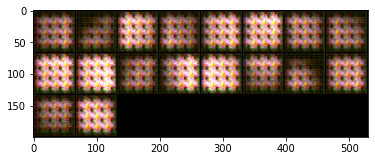

100%|██████████| 103/103 [00:36<00:00,  2.84it/s]


epoch: 1, lossD:1.4219087825238126, lossG:3.371373095558685,lossG_fake:1.8797512690997817, lossG_real:1.4916218391899925 ,equality:0.38812942990978927


evaluate:117.77342987060547,kid_mean:0.06682092696428299, kid_std:0.048699505627155304,kid_:(tensor(0.0668), tensor(0.0487))


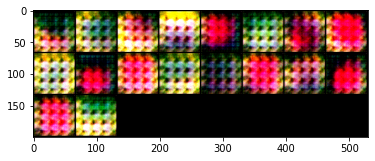

100%|██████████| 103/103 [00:36<00:00,  2.79it/s]


epoch: 2, lossD:1.6455059398725196, lossG:2.743250298268587,lossG_fake:1.5122571801676334, lossG_real:1.2309931053698642 ,equality:0.28126407479776927


evaluate:104.02132415771484,kid_mean:0.05522322282195091, kid_std:0.05419987812638283,kid_:(tensor(0.0552), tensor(0.0542))


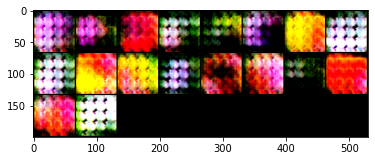

100%|██████████| 103/103 [00:36<00:00,  2.80it/s]


epoch: 3, lossD:1.7582493175580665, lossG:2.564629286238291,lossG_fake:1.3970416471796128, lossG_real:1.1675876367439344 ,equality:0.22945401043567837


evaluate:104.85047912597656,kid_mean:0.058584775775671005, kid_std:0.05590803921222687,kid_:(tensor(0.0586), tensor(0.0559))


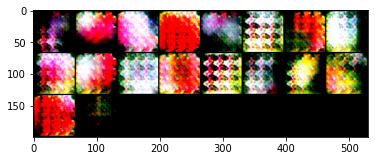

100%|██████████| 103/103 [00:37<00:00,  2.75it/s]


epoch: 4, lossD:1.736345689273575, lossG:2.5291626221925307,lossG_fake:1.3554005021030464, lossG_real:1.1737621218255423 ,equality:0.18163838027750412


evaluate:110.34254455566406,kid_mean:0.05952712520956993, kid_std:0.05769528076052666,kid_:(tensor(0.0595), tensor(0.0577))


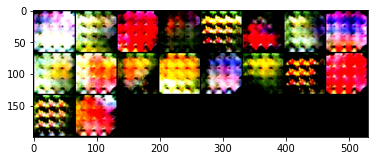

100%|██████████| 103/103 [00:37<00:00,  2.78it/s]


epoch: 5, lossD:1.7491206393658536, lossG:2.5784127272448494,lossG_fake:1.3846574165288685, lossG_real:1.1937553107159808 ,equality:0.1909021058128877


evaluate:111.2903060913086,kid_mean:0.06515451520681381, kid_std:0.05657832697033882,kid_:(tensor(0.0652), tensor(0.0566))


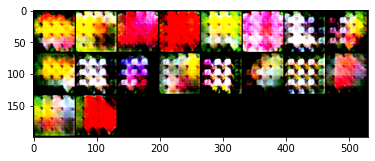

100%|██████████| 103/103 [00:36<00:00,  2.79it/s]


epoch: 6, lossD:1.7351748665559639, lossG:2.587543325516784,lossG_fake:1.3853712909429976, lossG_real:1.2021720444114463 ,equality:0.18319924653155129


evaluate:113.26900482177734,kid_mean:0.07260773330926895, kid_std:0.0631306916475296,kid_:(tensor(0.0726), tensor(0.0631))


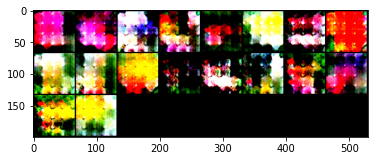

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 7, lossD:1.7530111595264917, lossG:2.532527317121191,lossG_fake:1.3354501782111752, lossG_real:1.19707712849367 ,equality:0.13837304971750508


evaluate:108.5396499633789,kid_mean:0.06569822132587433, kid_std:0.07231167703866959,kid_:(tensor(0.0657), tensor(0.0723))


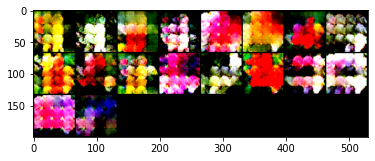

100%|██████████| 103/103 [00:37<00:00,  2.78it/s]


epoch: 8, lossD:1.7769727568024571, lossG:2.5117251340625355,lossG_fake:1.316113608554729, lossG_real:1.1956115243504348 ,equality:0.12050208420429409


evaluate:110.12638092041016,kid_mean:0.052184443920850754, kid_std:0.0486973337829113,kid_:(tensor(0.0522), tensor(0.0487))


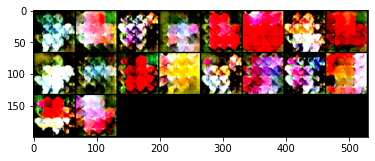

100%|██████████| 103/103 [00:37<00:00,  2.77it/s]


epoch: 9, lossD:1.8200251014487256, lossG:2.505480129741928,lossG_fake:1.332704385507454, lossG_real:1.172775739604987 ,equality:0.15992864590246714


evaluate:110.15462493896484,kid_mean:0.05658040940761566, kid_std:0.05496452748775482,kid_:(tensor(0.0566), tensor(0.0550))


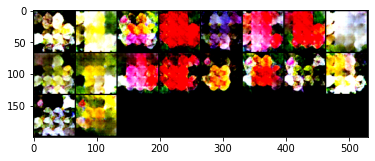

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 10, lossD:1.801137039962324, lossG:2.479105298958936,lossG_fake:1.304297302533122, lossG_real:1.1748079987405573 ,equality:0.12948930379256463


evaluate:107.64502716064453,kid_mean:0.07093210518360138, kid_std:0.06699232012033463,kid_:(tensor(0.0709), tensor(0.0670))


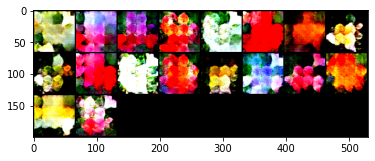

100%|██████████| 103/103 [00:37<00:00,  2.75it/s]


epoch: 11, lossD:1.9044092627404963, lossG:2.444648099177092,lossG_fake:1.2739973427022544, lossG_real:1.170650758789581 ,equality:0.10334658391267348


evaluate:108.62162780761719,kid_mean:0.0515780933201313, kid_std:0.04424561560153961,kid_:(tensor(0.0516), tensor(0.0442))


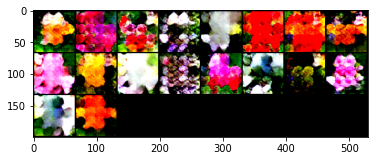

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 12, lossD:1.811534335312334, lossG:2.4084246019715243,lossG_fake:1.2727325645465295, lossG_real:1.1356920443692253 ,equality:0.13704052017730417


evaluate:113.74726104736328,kid_mean:0.06875663995742798, kid_std:0.062141790986061096,kid_:(tensor(0.0688), tensor(0.0621))


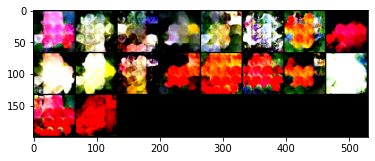

100%|██████████| 103/103 [00:38<00:00,  2.68it/s]


epoch: 13, lossD:1.839315382022302, lossG:2.410539525226482,lossG_fake:1.2679283341157783, lossG_real:1.14261118879596 ,equality:0.1253171453198183


evaluate:115.61827087402344,kid_mean:0.07513830810785294, kid_std:0.07276657968759537,kid_:(tensor(0.0751), tensor(0.0728))


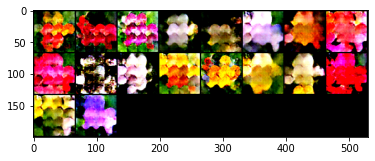

100%|██████████| 103/103 [00:37<00:00,  2.73it/s]


epoch: 14, lossD:1.8524035666752787, lossG:2.3896080429114184,lossG_fake:1.2390758354686997, lossG_real:1.1505322062853471 ,equality:0.08854362918335257


evaluate:115.68021392822266,kid_mean:0.08172973990440369, kid_std:0.07341725379228592,kid_:(tensor(0.0817), tensor(0.0734))


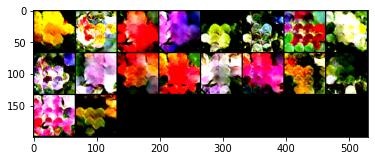

100%|██████████| 103/103 [00:37<00:00,  2.73it/s]


epoch: 15, lossD:1.820052134180532, lossG:2.3814373247831773,lossG_fake:1.2455938458442688, lossG_real:1.135843475466793 ,equality:0.10975037037747581


evaluate:115.07462310791016,kid_mean:0.07495817542076111, kid_std:0.06341682374477386,kid_:(tensor(0.0750), tensor(0.0634))


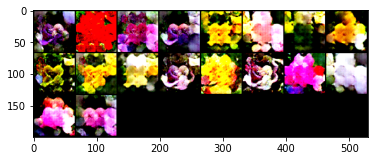

100%|██████████| 103/103 [00:38<00:00,  2.66it/s]


epoch: 16, lossD:1.8529842270230783, lossG:2.3757084110408155,lossG_fake:1.2231699164631298, lossG_real:1.1525384858973975 ,equality:0.07063143056573229


evaluate:117.79861450195312,kid_mean:0.07558074593544006, kid_std:0.06545668840408325,kid_:(tensor(0.0756), tensor(0.0655))


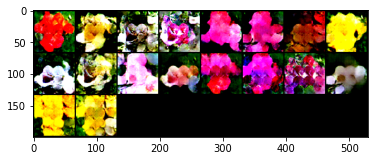

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 17, lossD:1.8263562686235002, lossG:2.397799890018204,lossG_fake:1.2669448418524658, lossG_real:1.1308550452723087 ,equality:0.13608979658015707


evaluate:117.6923599243164,kid_mean:0.07095517218112946, kid_std:0.059942129999399185,kid_:(tensor(0.0710), tensor(0.0599))


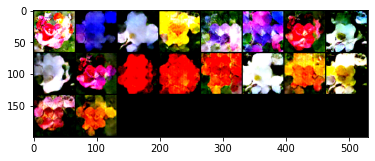

100%|██████████| 103/103 [00:37<00:00,  2.75it/s]


epoch: 18, lossD:2.0199976233602728, lossG:2.3342211408522524,lossG_fake:1.2280253495984865, lossG_real:1.106195804563541 ,equality:0.12182954503494559


evaluate:117.13036346435547,kid_mean:0.08594231307506561, kid_std:0.06878539174795151,kid_:(tensor(0.0859), tensor(0.0688))


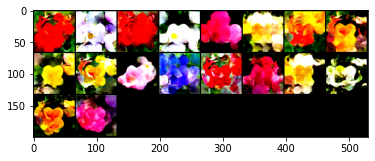

100%|██████████| 103/103 [00:38<00:00,  2.67it/s]


epoch: 19, lossD:1.8352685113555018, lossG:2.317280591112896,lossG_fake:1.1998337171610118, lossG_real:1.1174468617994808 ,equality:0.08238685536153101


evaluate:116.91756439208984,kid_mean:0.07506018877029419, kid_std:0.062383588403463364,kid_:(tensor(0.0751), tensor(0.0624))


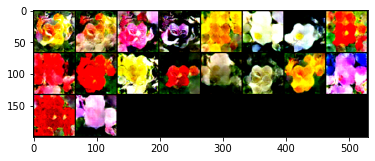

100%|██████████| 103/103 [00:37<00:00,  2.73it/s]


epoch: 20, lossD:1.8879456508506849, lossG:2.3702947005484867,lossG_fake:1.2283573029110733, lossG_real:1.141937400530843 ,equality:0.08641990238023034


evaluate:114.76766967773438,kid_mean:0.07694241404533386, kid_std:0.06511632353067398,kid_:(tensor(0.0769), tensor(0.0651))


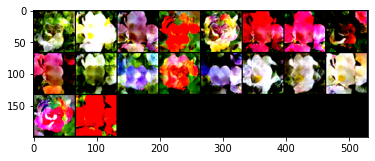

100%|██████████| 103/103 [00:37<00:00,  2.72it/s]


epoch: 21, lossD:1.8392946164584854, lossG:2.3664037625766494,lossG_fake:1.2209596356141914, lossG_real:1.1454441252264005 ,equality:0.07551551038779092


evaluate:113.21397399902344,kid_mean:0.07043628394603729, kid_std:0.06064963340759277,kid_:(tensor(0.0704), tensor(0.0606))


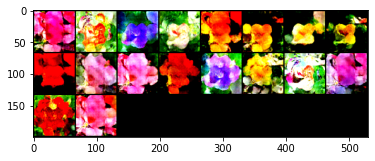

100%|██████████| 103/103 [00:37<00:00,  2.75it/s]


epoch: 22, lossD:1.8178871696435133, lossG:2.3876668781910126,lossG_fake:1.2398542165756226, lossG_real:1.1478126569859033 ,equality:0.09204155958971927


evaluate:112.49861145019531,kid_mean:0.06950980424880981, kid_std:0.057201214134693146,kid_:(tensor(0.0695), tensor(0.0572))


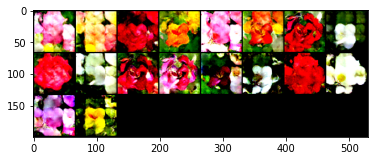

100%|██████████| 103/103 [00:37<00:00,  2.76it/s]


epoch: 23, lossD:1.9216171155855493, lossG:2.443306677549788,lossG_fake:1.2696320171495086, lossG_real:1.1736746638723947 ,equality:0.09595735327711385


evaluate:112.31076049804688,kid_mean:0.06659869104623795, kid_std:0.06320549547672272,kid_:(tensor(0.0666), tensor(0.0632))


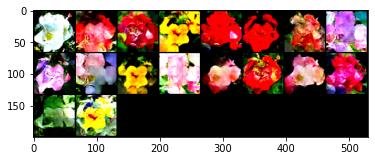

100%|██████████| 103/103 [00:37<00:00,  2.76it/s]


epoch: 24, lossD:1.8222214724253682, lossG:2.3765744815752345,lossG_fake:1.2274173093073577, lossG_real:1.1491571670597038 ,equality:0.07826014224765387


evaluate:113.91754913330078,kid_mean:0.06562594324350357, kid_std:0.058141227811574936,kid_:(tensor(0.0656), tensor(0.0581))


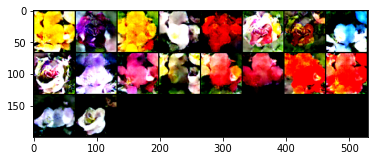

100%|██████████| 103/103 [00:37<00:00,  2.76it/s]


epoch: 25, lossD:1.8169186821261656, lossG:2.411654185322882,lossG_fake:1.260066992449529, lossG_real:1.1515871963454682 ,equality:0.10847979610406067


evaluate:112.84136199951172,kid_mean:0.07262630760669708, kid_std:0.06347222626209259,kid_:(tensor(0.0726), tensor(0.0635))


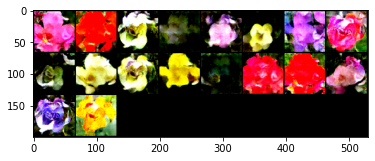

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 26, lossD:1.831724555747023, lossG:2.4166335156820353,lossG_fake:1.2563773873940254, lossG_real:1.160256140440413 ,equality:0.09612124695361235


evaluate:111.64701080322266,kid_mean:0.07334762811660767, kid_std:0.0734560489654541,kid_:(tensor(0.0733), tensor(0.0735))


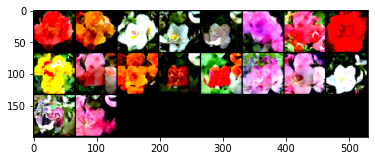

100%|██████████| 103/103 [00:37<00:00,  2.75it/s]


epoch: 27, lossD:1.986497641767113, lossG:2.4479329076785485,lossG_fake:1.2641952674365737, lossG_real:1.1837376367698595 ,equality:0.08045763066671419


evaluate:111.60166931152344,kid_mean:0.06887094676494598, kid_std:0.06547149270772934,kid_:(tensor(0.0689), tensor(0.0655))


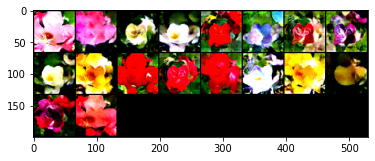

100%|██████████| 103/103 [00:37<00:00,  2.76it/s]


epoch: 28, lossD:1.8056495884089794, lossG:2.3831017457165764,lossG_fake:1.2226296304499062, lossG_real:1.1604721089011256 ,equality:0.062157521548780625


evaluate:111.06460571289062,kid_mean:0.06122713163495064, kid_std:0.056534454226493835,kid_:(tensor(0.0612), tensor(0.0565))


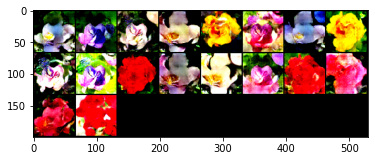

100%|██████████| 103/103 [00:37<00:00,  2.76it/s]


epoch: 29, lossD:1.8138576815429244, lossG:2.4265613810529985,lossG_fake:1.2454093393770236, lossG_real:1.1811520387825456 ,equality:0.06425730059447798


evaluate:110.47350311279297,kid_mean:0.06890010088682175, kid_std:0.0596725158393383,kid_:(tensor(0.0689), tensor(0.0597))


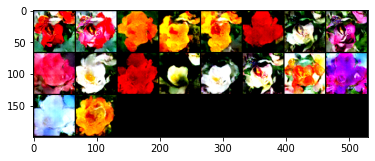

100%|██████████| 103/103 [00:37<00:00,  2.75it/s]


epoch: 30, lossD:1.8227538275487214, lossG:2.4649835165264538,lossG_fake:1.2747049077043255, lossG_real:1.1902785995631542 ,equality:0.08442630814117136


evaluate:110.94343566894531,kid_mean:0.06075624004006386, kid_std:0.058076411485672,kid_:(tensor(0.0608), tensor(0.0581))


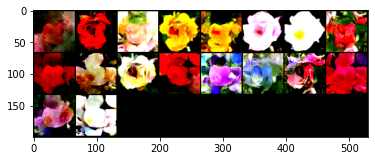

100%|██████████| 103/103 [00:37<00:00,  2.72it/s]


epoch: 31, lossD:1.844370803786713, lossG:2.446177609915872,lossG_fake:1.2706335840873348, lossG_real:1.1755440293006527 ,equality:0.09508955478668213


evaluate:110.45242309570312,kid_mean:0.06825905293226242, kid_std:0.05202215909957886,kid_:(tensor(0.0683), tensor(0.0520))


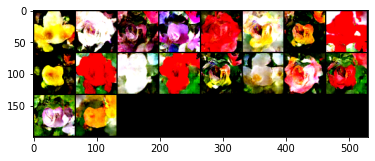

100%|██████████| 103/103 [00:38<00:00,  2.71it/s]


epoch: 32, lossD:1.8043715016355792, lossG:2.4739085632620506,lossG_fake:1.2746652573057748, lossG_real:1.1992433036415322 ,equality:0.07542195366424265


evaluate:111.46520233154297,kid_mean:0.06760968267917633, kid_std:0.05731181427836418,kid_:(tensor(0.0676), tensor(0.0573))


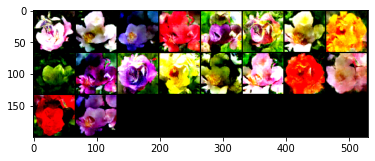

100%|██████████| 103/103 [00:37<00:00,  2.72it/s]


epoch: 33, lossD:1.7906924995403846, lossG:2.4950815288765917,lossG_fake:1.2876378338313796, lossG_real:1.2074436840501803 ,equality:0.08019414978119932


evaluate:111.67391967773438,kid_mean:0.07624196261167526, kid_std:0.06127617508172989,kid_:(tensor(0.0762), tensor(0.0613))


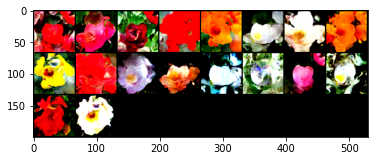

100%|██████████| 103/103 [00:38<00:00,  2.70it/s]


epoch: 34, lossD:1.7871160391464973, lossG:2.51859778339423,lossG_fake:1.3056111092706328, lossG_real:1.2129866700727963 ,equality:0.09262443919783658


evaluate:112.5671615600586,kid_mean:0.07486018538475037, kid_std:0.0688401609659195,kid_:(tensor(0.0749), tensor(0.0688))


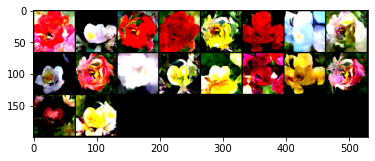

100%|██████████| 103/103 [00:38<00:00,  2.71it/s]


epoch: 35, lossD:1.7696291428167843, lossG:2.5458247129199574,lossG_fake:1.3051176869753496, lossG_real:1.2407070288380373 ,equality:0.06441065813731228


evaluate:112.8906478881836,kid_mean:0.06797118484973907, kid_std:0.07023809850215912,kid_:(tensor(0.0680), tensor(0.0702))


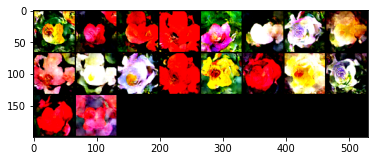

100%|██████████| 103/103 [00:38<00:00,  2.69it/s]


epoch: 36, lossD:1.803279351262213, lossG:2.5266784533713627,lossG_fake:1.2990153518695275, lossG_real:1.2276631055526364 ,equality:0.07135224631689119


evaluate:113.15863800048828,kid_mean:0.0699877217411995, kid_std:0.05685114860534668,kid_:(tensor(0.0700), tensor(0.0569))


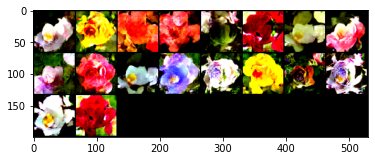

100%|██████████| 103/103 [00:38<00:00,  2.71it/s]


epoch: 37, lossD:1.7579598970783568, lossG:2.5545165747114758,lossG_fake:1.3154935344909002, lossG_real:1.239023033276345 ,equality:0.07647050121455523


evaluate:113.13088989257812,kid_mean:0.06845742464065552, kid_std:0.0660429373383522,kid_:(tensor(0.0685), tensor(0.0660))


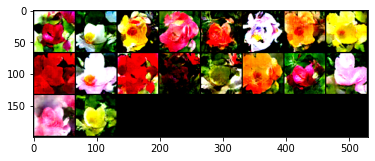

100%|██████████| 103/103 [00:38<00:00,  2.69it/s]


epoch: 38, lossD:1.7714405858400957, lossG:2.6004334468286014,lossG_fake:1.3316314937998948, lossG_real:1.2688019420336751 ,equality:0.06282955176621963


evaluate:113.70088958740234,kid_mean:0.07334143668413162, kid_std:0.063339002430439,kid_:(tensor(0.0733), tensor(0.0633))


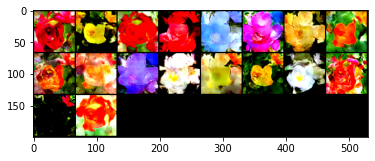

100%|██████████| 103/103 [00:38<00:00,  2.69it/s]


epoch: 39, lossD:1.7607459096075262, lossG:2.5775094055435033,lossG_fake:1.3429636226117032, lossG_real:1.2345457904547164 ,equality:0.10841783215698686


evaluate:112.88138580322266,kid_mean:0.07142911851406097, kid_std:0.06498764455318451,kid_:(tensor(0.0714), tensor(0.0650))


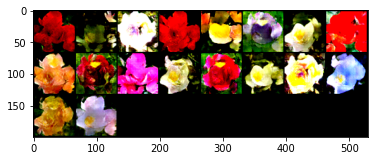

100%|██████████| 103/103 [00:37<00:00,  2.73it/s]


epoch: 40, lossD:1.7349838354055165, lossG:2.6061666405316695,lossG_fake:1.3438285652873585, lossG_real:1.2623380659853372 ,equality:0.08149049930202135


evaluate:111.83705139160156,kid_mean:0.063929483294487, kid_std:0.05446496233344078,kid_:(tensor(0.0639), tensor(0.0545))


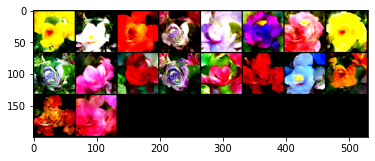

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 41, lossD:1.7471396842049163, lossG:2.6487137275992088,lossG_fake:1.3547238904295615, lossG_real:1.293989833697532 ,equality:0.060734056732029584


evaluate:112.36560821533203,kid_mean:0.07092748582363129, kid_std:0.06708298623561859,kid_:(tensor(0.0709), tensor(0.0671))


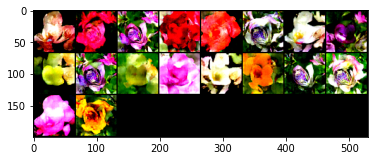

100%|██████████| 103/103 [00:37<00:00,  2.71it/s]


epoch: 42, lossD:1.696154727519137, lossG:2.668049844723303,lossG_fake:1.3797852078687798, lossG_real:1.2882646374332094 ,equality:0.09152057043557038


evaluate:108.37999725341797,kid_mean:0.06569617986679077, kid_std:0.059483956545591354,kid_:(tensor(0.0657), tensor(0.0595))


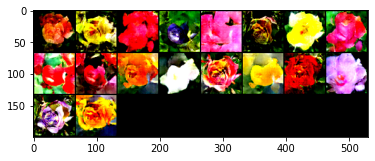

100%|██████████| 103/103 [00:37<00:00,  2.72it/s]


epoch: 43, lossD:1.8459955523314986, lossG:2.6883128129162834,lossG_fake:1.3934573687396004, lossG_real:1.2948554395471963 ,equality:0.09860192919240407


evaluate:108.33612823486328,kid_mean:0.07395222783088684, kid_std:0.0597836896777153,kid_:(tensor(0.0740), tensor(0.0598))


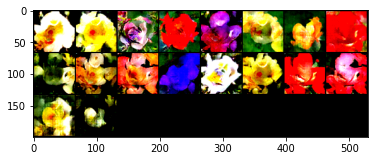

100%|██████████| 103/103 [00:37<00:00,  2.74it/s]


epoch: 44, lossD:1.6507735287101524, lossG:2.663769654857302,lossG_fake:1.3753146372952507, lossG_real:1.288455019876795 ,equality:0.08685961741845571


evaluate:108.81774139404297,kid_mean:0.07573758065700531, kid_std:0.06962709128856659,kid_:(tensor(0.0757), tensor(0.0696))


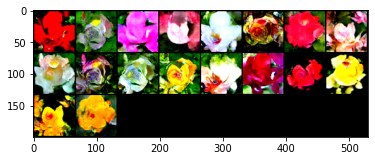

100%|██████████| 103/103 [00:38<00:00,  2.69it/s]


epoch: 45, lossD:1.6788580649107405, lossG:2.7282943887617983,lossG_fake:1.4089265407867801, lossG_real:1.3193678601274212 ,equality:0.0895586806593589


evaluate:108.68607330322266,kid_mean:0.08502772450447083, kid_std:0.07090704888105392,kid_:(tensor(0.0850), tensor(0.0709))


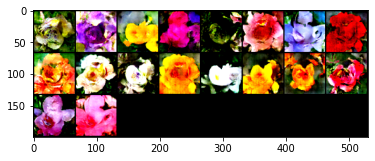

100%|██████████| 103/103 [00:37<00:00,  2.73it/s]


epoch: 46, lossD:1.6943785496128416, lossG:2.7082179194515192,lossG_fake:1.3960861390076795, lossG_real:1.3121317891241278 ,equality:0.08395434988355177


evaluate:107.17726135253906,kid_mean:0.07299535721540451, kid_std:0.0548994317650795,kid_:(tensor(0.0730), tensor(0.0549))


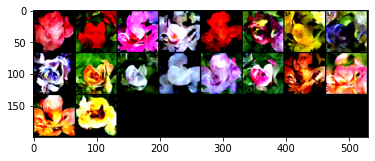

100%|██████████| 103/103 [00:37<00:00,  2.72it/s]


epoch: 47, lossD:1.6341874367982439, lossG:2.7594546183799076,lossG_fake:1.4178966330093088, lossG_real:1.3415579871066565 ,equality:0.07633864590265227


evaluate:107.82259368896484,kid_mean:0.05915434658527374, kid_std:0.052818652242422104,kid_:(tensor(0.0592), tensor(0.0528))


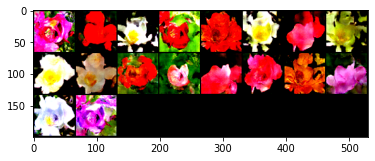

100%|██████████| 103/103 [00:38<00:00,  2.68it/s]


epoch: 48, lossD:1.6484941926974694, lossG:2.790624382426438,lossG_fake:1.4316520297411577, lossG_real:1.3589723573147672 ,equality:0.07267967242639051


evaluate:107.86553955078125,kid_mean:0.07305313646793365, kid_std:0.07063969224691391,kid_:(tensor(0.0731), tensor(0.0706))


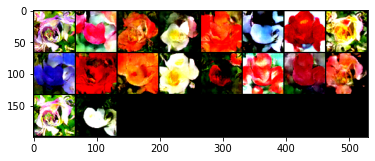

100%|██████████| 103/103 [00:37<00:00,  2.73it/s]


epoch: 49, lossD:1.7251034465808313, lossG:2.7813074195269243,lossG_fake:1.4233854216279336, lossG_real:1.357921996162933 ,equality:0.06546342546500061


evaluate:108.49455261230469,kid_mean:0.06472774595022202, kid_std:0.056681860238313675,kid_:(tensor(0.0647), tensor(0.0567))


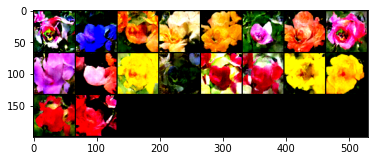

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

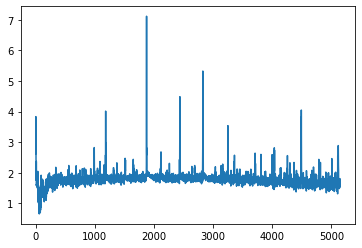

In [45]:
plt.plot(raw_lossesD)

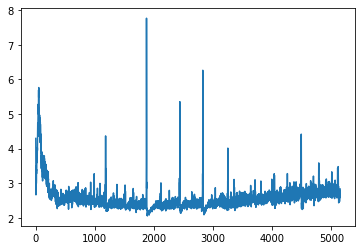

In [46]:
plt.plot(raw_lossesG)

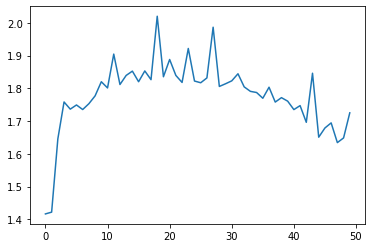

In [47]:
plt.plot(lossesD)

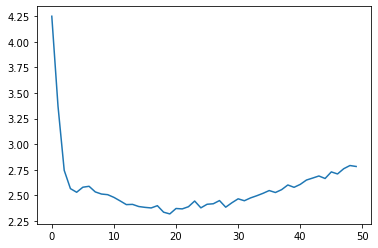

In [48]:
plt.plot(lossesG)

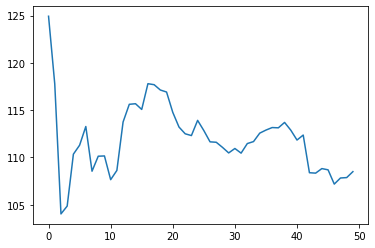

In [49]:
plt.plot(fid_)

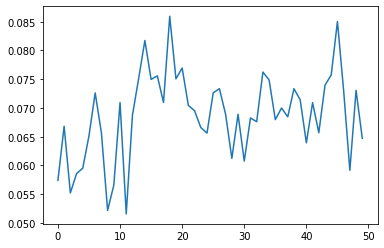

In [50]:
plt.plot(kid_mean_)

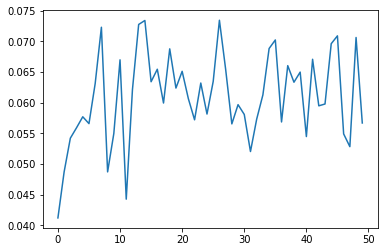

In [51]:
plt.plot(kid_std_)

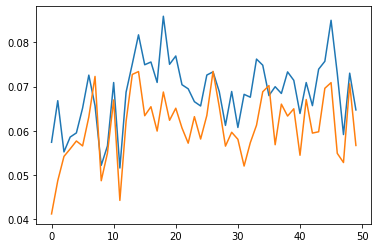

In [52]:
plt.plot(kid_score)

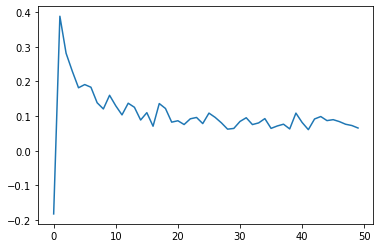

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0730), tensor(0.0658))